### 1. Load packages

In [1]:
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
import WEST_plt

file_path = '/home/stat/cai/WEST/data/simulation/circle_grid_disp_0.2/'

2024-05-22 16:25:30.885989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 16:25:31.062408: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-22 16:25:31.955534: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-22 16:25:31.955696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### 2. Load data

In [2]:
#### Gene expression
X = pd.read_csv(file_path + 'X.csv')
#### Spatial location
S = pd.read_csv(file_path + 'S.csv')

#### Construct adata object
adata = anndata.AnnData(pd.DataFrame(X.to_numpy()))

adata.obs['loc_x'] =  S['x'].to_numpy()
adata.obs['loc_y'] =  S['y'].to_numpy()

#### Real cluster
adata.obs["true cluster"] =  S['cluster'].to_numpy()
adata.obs["true cluster"] = adata.obs["true cluster"].astype("category")

/home/stat/anaconda3/envs/WEST/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/stat/anaconda3/envs/WEST/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [3]:
#### Save data as pickle
with open(file_path+'raw_data.pkl', 'wb') as file:
    pickle.dump(adata, file)

# #### Read data from pickle
# with open('raw_data.pkl', 'rb') as file:
#     adata = pickle.load(file)

### 3. Preprocess

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4) # Normalization
sc.pp.log1p(adata) # Take log
sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=True) # Gene screening
sc.pp.pca(adata, n_comps=30) # PCA
sc.pp.neighbors(adata, n_neighbors=100) # use PCA as default

/home/stat/anaconda3/envs/gcn2/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


### 4. Clustering

In [10]:
sc.tl.leiden(adata, key_added='Leiden', resolution=1.0) # Cluster using leiden
ARI = adjusted_rand_score(adata.obs['Leiden'], adata.obs['true cluster']) # ARI of the cluster result only use gene expression
print('ARI: ', ARI)
print(adata.obs['Leiden'].unique())
print(adata.obs['true cluster'].unique())

ARI:  0.20709794370303786
['0', '1', '3', '2', '4', '6', '5']
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']
[1, 2, 3, 4, 5, 6]
Categories (6, int64): [1, 2, 3, 4, 5, 6]


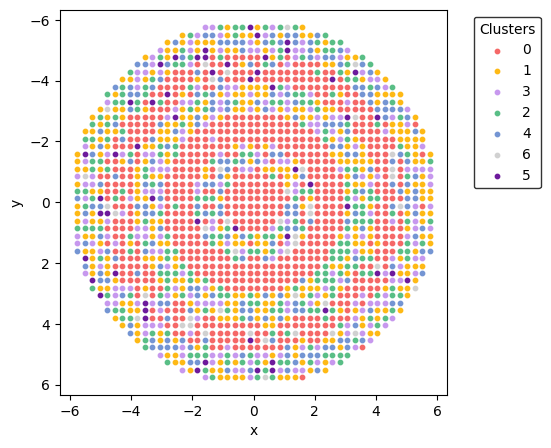

In [8]:
WEST_plt.WEST_scatter(adata, reps='Leiden', invert_y=True, s=10)

### 5. Save embedding

In [11]:
np.savetxt(file_path+'Leiden_embedding.csv', adata.obsm['X_pca'], delimiter=',')
np.savetxt(file_path+'Leiden_cluster.csv', adata.obs['Leiden'], delimiter=',', fmt='%s')